In [1]:
# -------------------------
# Imports
# -------------------------

import warnings, logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm, t as student_t

from tqdm import tqdm
warnings.filterwarnings("ignore")
logging.getLogger("statsmodels").setLevel(logging.ERROR)

In [2]:
# -------------------------
# Config
# -------------------------

CSV    = "data_main.csv"
DATE   = "date"
TARGET = "log_total_dollar_volume"
EXOG   = "vix_close"

USE_LAGS = True
MAX_LAGS  = 3

MAX_P = 5
MAX_Q = 5
MAX_D = 1

SPLITS = [
    dict(train_start=None,          train_end="2022-12-31", test_start="2023-01-01"),
    dict(train_start="2020-03-01",  train_end="2022-12-31", test_start="2023-01-01"),
]

In [3]:
# -------------------------
# Data
# -------------------------

df = pd.read_csv(CSV, parse_dates=[DATE]).set_index(DATE).sort_index()
df = df.asfreq("B").ffill()

y = df[TARGET].astype(float)
vix_full = df[EXOG].astype(float)

if USE_LAGS:
    X = pd.DataFrame({
        f"vix_lag{L}": vix_full.shift(L)
        for L in range(1, MAX_LAGS + 1)
    })
else:
    X = vix_full.to_frame("vix")

def align_xy_dropna(y, X):
    y2, X2 = y.align(X, join="inner")
    mask = np.isfinite(y2.values) & np.isfinite(X2.values).all(axis=1)
    return y2[mask], X2[mask]

In [4]:
# -------------------------
# Parameter Estimation (p, d, q)
# -------------------------

def aicc(res):
    k = res.params.size
    n = res.nobs
    return res.aic + (2 * k * (k + 1)) / max(n - k - 1, 1)


def fit_best_sarimax(y_train, X_train, use_exog):
    best_ic, best_res, best_order = np.inf, None, None

    if use_exog:
        y_train, X_train = align_xy_dropna(y_train, X_train)
    else:
        y_train = y_train.dropna()
        X_train = None

    for p in range(MAX_P + 1):
        for d in range(MAX_D + 1):
            for q in range(MAX_Q + 1):
                try:
                    m = SARIMAX(
                        y_train,
                        exog=X_train if use_exog else None,
                        order=(p, d, q),
                        enforce_stationarity=False
                    )
                    res = m.fit(disp=False)
                    ic = aicc(res)
                    if ic < best_ic:
                        best_ic, best_res, best_order = ic, res, (p, d, q)
                except Exception:
                    pass

    return best_res, best_order

In [5]:
# -------------------------
# Residual Diagnostics (GARCH)
# -------------------------

def garch_diagnostics(garch_res):
    z = pd.Series(garch_res.std_resid).dropna()
    lags = min(20, int(10 * np.log10(len(z))))
    lb_p = acorr_ljungbox(z, lags=[lags], return_df=True)["lb_pvalue"].iloc[-1]
    _, arch_p, _, _ = het_arch(z, nlags=lags)
    _, jb_p, _, _ = jarque_bera(z)
    dw = durbin_watson(z)
    return dict(dw=dw, lb_p=lb_p, arch_p=arch_p, jb_p=jb_p)

In [6]:
# -------------------------
# Fit Garch Model
# -------------------------

def fit_garch(res):
    resid_raw = pd.Series(res.resid).dropna()
    burn = getattr(res, "loglikelihood_burn", 0)
    resid = resid_raw.iloc[burn:]

    am = arch_model(resid, mean="Zero", vol="GARCH", p=1, q=1, dist="t")
    return am.fit(disp="off")

In [7]:
# -------------------------
# Forecast 
# -------------------------

def forecast_1step(res, garch_res, y_test, X_test=None, alpha=0.05):

    omega = garch_res.params["omega"]
    alpha1 = garch_res.params[[k for k in garch_res.params.index if "alpha" in k][0]]
    beta1  = garch_res.params[[k for k in garch_res.params.index if "beta"  in k][0]]

    sigma2 = garch_res.conditional_volatility.iloc[-1] ** 2
    eps = garch_res.resid.iloc[-1]

    z = student_t.ppf(1 - alpha / 2, garch_res.params["nu"])

    mu, sig, lo, hi = [], [], [], []

    res_curr = res

    for t in y_test.index:
        ex = None if X_test is None else X_test.loc[[t]]
        fc = res_curr.get_forecast(1, exog=ex)
        mu_t = fc.predicted_mean.iloc[0]

        sigma2 = omega + alpha1 * eps**2 + beta1 * sigma2
        sigma = np.sqrt(sigma2)

        mu.append(mu_t)
        sig.append(sigma)
        lo.append(mu_t - z * sigma)
        hi.append(mu_t + z * sigma)

        eps = y_test.loc[t] - mu_t
        res_curr = res_curr.append([y_test.loc[t]], exog=ex, refit=False)

    mu = pd.Series(mu, index=y_test.index)
    sig = pd.Series(sig, index=y_test.index)
    lo = pd.Series(lo, index=y_test.index)
    hi = pd.Series(hi, index=y_test.index)

    return dict(
        y_te=y_test,
        mean=mu,
        sigma=sig,
        lower=lo,
        upper=hi,
        mae=mean_absolute_error(y_test, mu),
        rmse=np.sqrt(mean_squared_error(y_test, mu)),
    )

In [8]:
# -------------------------
# Results
# -------------------------

RESULTS = {"ARIMA_GARCH": [], "ARIMAX_GARCH": []}

for i, sp in tqdm(enumerate(SPLITS, 1), total=len(SPLITS), desc="Running splits"):
    y_train = y.loc[:sp["train_end"]] if sp["train_start"] is None else y.loc[sp["train_start"]:sp["train_end"]]
    y_test = y.loc[sp["test_start"]:]

    X_train = X.loc[y_train.index]
    X_test  = X.loc[y_test.index]

    mu_x = X_train.mean()
    sd_x = X_train.std().replace(0, 1)
    X_train = (X_train - mu_x) / sd_x
    X_test  = (X_test  - mu_x) / sd_x

    # ARIMA-GARCH
    res, order = fit_best_sarimax(y_train, None, False)
    garch = fit_garch(res)
    fc = forecast_1step(res, garch, y_test)

    RESULTS["ARIMA_GARCH"].append({
        "split": i,
        "order": order,
        "diag_garch": garch_diagnostics(garch),
        "forecast": fc,
    })
    
    # ARIMAX-GARCH
    resx, orderx = fit_best_sarimax(y_train, X_train, True)
    garchx = fit_garch(resx)
    fcx = forecast_1step(resx, garchx, y_test, X_test)

    RESULTS["ARIMAX_GARCH"].append({
        "split": i,
        "order": orderx,
        "diag_garch": garch_diagnostics(garchx),
        "forecast": fcx,
    })

Running splits: 100%|██████████| 2/2 [32:12<00:00, 966.19s/it] 


In [9]:
# -------------------------
# Collect Results to Data Frame
# -------------------------

def collect_metrics(RESULTS):
    rows = []
    for model, runs in RESULTS.items():
        for run in runs:
            fc = run["forecast"]
            rows.append({
                "model": model,
                "split": run["split"],
                "order": run["order"],
                "mae": fc["mae"],
                "rmse": fc["rmse"],
                **run["diag_garch"],
            })
    return pd.DataFrame(rows)

In [10]:
metrics = collect_metrics(RESULTS)
print(metrics)

          model  split      order       mae      rmse        dw          lb_p  \
0   ARIMA_GARCH      1  (4, 1, 4)  0.103523  0.156365  2.020764  3.222189e-07   
1   ARIMA_GARCH      2  (2, 1, 1)  0.106772  0.159532  1.928517  9.215931e-01   
2  ARIMAX_GARCH      1  (5, 1, 5)  0.103532  0.156276  2.013529  3.414137e-06   
3  ARIMAX_GARCH      2  (2, 1, 1)  0.106966  0.158953  1.929137  9.063442e-01   

         arch_p           jb_p  
0  8.618920e-07   0.000000e+00  
1  1.036459e-02  1.594396e-210  
2  7.472246e-07   0.000000e+00  
3  1.315513e-02  1.398637e-224  


In [11]:
# -------------------------
# Plot
# -------------------------
def plot_forecast(run, title=None):
    fc = run["forecast"]
    plt.figure(figsize=(12, 5))
    plt.plot(fc["y_te"], label="Actual")
    plt.plot(fc["mean"], label="Forecast")
    plt.fill_between(fc["mean"].index, fc["lower"], fc["upper"], alpha=0.2)
    plt.title(title or f"Split {run['split']} | {run['order']}")
    plt.legend()
    plt.tight_layout()
    plt.show()

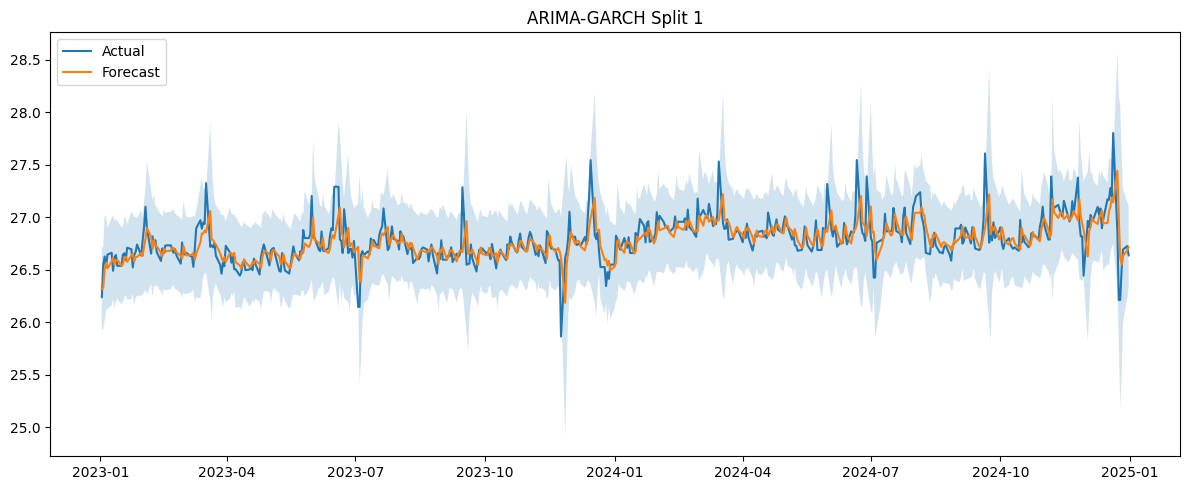

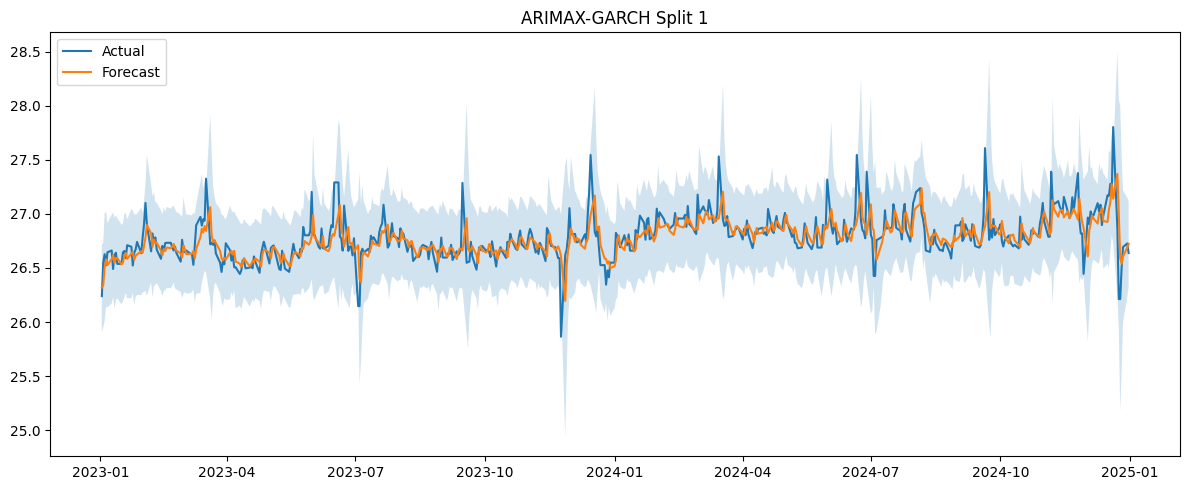

In [12]:
plot_forecast(RESULTS["ARIMA_GARCH"][0], "ARIMA-GARCH Split 1")
plot_forecast(RESULTS["ARIMAX_GARCH"][0], "ARIMAX-GARCH Split 1")